In [1]:
import requests
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from sklearn.cluster import KMeans, DBSCAN
import h5pyd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import cKDTree
from sklearn import preprocessing
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
pio.renderers.default = 'iframe'
%matplotlib inline

In [141]:
def get_stations(lat=40,lon=-105,radius=1000):
    uri_stations=f'https://developer.nrel.gov/api/solar/data_query/v1.json?api_key={api_key}&lat={lat}&lon={lon}&radius={radius}&all=1'
    rstations = requests.get(uri_stations)
    print(rstations)
    stations = rstations.json()['outputs']['all_stations']
    return stations
   
def get_data(lat=40,lon=-105,radius=0):
    uri_data=f'https://developer.nrel.gov/api/solar/solar_resource/v1.json?api_key={api_key}&lat={lat}&lon={lon}&radius={radius}&all=1'
    rdata = requests.get(uri_data)
    data = rdata.json()['outputs']
    return data

def get_energy(lat=40,lon=-105,radius=0,capacity=4,azimuth=180,tilt=0,array_type=0,module_type=0,losses=10):
    uri_energy=f'https://developer.nrel.gov/api/pvwatts/v6.json?api_key={api_key}&lat={lat}&lon={lon}&radius={radius}'
    uri_energy+=f'&system_capacity={capacity}&azimuth={azimuth}&tilt={tilt}&array_type={array_type}&module_type={module_type}&losses={losses}'
    print(lat,lon)
    renergy = requests.get(uri_energy)
    data = renergy.json()['outputs']
    return data
                         
def build_ds(lat=40,lon=-105,radius=1000):
    ds = pd.DataFrame()
    stations = get_stations(lat=lat,lon=lon,radius=radius)
    for e in stations:
        if e['dataset'] == 'tmy3':
            try:
                data = get_data(e['lat'],e['lon'])
                entry = {'lat':e['lat'],
                     'lon':e['lon'],
                     'elevation':e['elevation'],
                     'avg_dni_annual':data['avg_dni']['annual'],
                     'avg_ghi_annual':data['avg_ghi']['annual'],
                     'avg_lat_tilt_annual':data['avg_lat_tilt']['annual']}
                for m,v in data['avg_dni']['monthly'].items():
                    entry[f'avg_dni_{m}'] = v
                for m,v in data['avg_ghi']['monthly'].items():
                    entry[f'avg_ghi_{m}'] = v
                for m,v in data['avg_lat_tilt']['monthly'].items():
                    entry[f'avg_lat_tilt_{m}'] = v                        
                ds = ds.append(entry, ignore_index=True)
            except:
                pass
    return ds

def closest_lat_lon(df,lat=40,lon=-105):
    lats = df['latitude'].values
    lons = df['longitude'].values
    diff = np.inf
    index = 0
    for i in range(len(lats)):
        dist = (lat-lats[i])**2+(lon-lons[i])**2
        if dist < diff:
            index = i
            diff = dist
    return index        

def get_corrs(df,lat=40,lon=-105,features=None):
    min_max_scaler = preprocessing.MinMaxScaler()
    if features is None:
        features = [c for c in df.columns if c != 'latitude' and 
                c != 'longitude' and c != 'cluster']# and 
                #c != 'wind_speed' and c != 'clearsky_dhi' and
                #c != 'clearsky_dni' and c != 'clearsky_ghi' and
                #c != 'elevation' and c != 'landcover']
    x_scaled = min_max_scaler.fit_transform(df[features])
    df_scaled = pd.DataFrame(x_scaled)
    df_corrs = df_scaled.T.corr()
    return df_corrs.iloc[closest_lat_lon(df,lat,lon)]

def get_rad_data(timestep,spatial_index):
    df['ghi'] = f['ghi'][timestep,spatial_index]/f['ghi'].attrs['psm_scale_factor']
    df['dni'] = f['dni'][timestep,spatial_index]/f['dni'].attrs['psm_scale_factor']
    df['dhi'] = f['dhi'][timestep,spatial_index]/f['dhi'].attrs['psm_scale_factor']
    df['dew_point'] = f['dew_point'][timestep,spatial_index]/f['dew_point'].attrs['psm_scale_factor']
    df['solar_zenith_angle'] = f['solar_zenith_angle'][timestep,spatial_index]/f['solar_zenith_angle'].attrs['psm_scale_factor']
    df['total_precip'] = f['total_precipitable_water'][timestep,spatial_index]/f['total_precipitable_water'].attrs['psm_scale_factor']
    df['air_temp'] = f['air_temperature'][timestep,spatial_index]/f['air_temperature'].attrs['psm_scale_factor']
    df['wind_speed'] = f['wind_speed'][timestep,spatial_index]/f['wind_speed'].attrs['psm_scale_factor']
    df['relative_humidity'] = f['relative_humidity'][timestep,spatial_index]/f['relative_humidity'].attrs['psm_scale_factor']
    df['surface_albedo'] = f['surface_albedo'][timestep,spatial_index]/f['surface_albedo'].attrs['psm_scale_factor']
    df['cloud_type'] = f['cloud_type'][timestep,spatial_index]/f['cloud_type'].attrs['psm_scale_factor']
    df['clearsky_dhi'] = f['clearsky_dhi'][timestep,spatial_index]/f['clearsky_dhi'].attrs['psm_scale_factor']
    df['clearsky_dni'] = f['clearsky_dni'][timestep,spatial_index]/f['clearsky_dni'].attrs['psm_scale_factor']
    df['clearsky_ghi'] = f['clearsky_ghi'][timestep,spatial_index]/f['clearsky_ghi'].attrs['psm_scale_factor']
    return df

def get_avg_field(field,spatial_index,stride=10):
    tmp = []#[0]*len(spatial_index)
    for i in tqdm(spatial_index):
        tmp.append(np.mean(f[field][::stride,i]/f[field].attrs['psm_scale_factor']))
    return tmp

def add_mean_field(field,spatial_index,stride=1000):
    df[field] = get_avg_field(field,spatial_index,stride)
    return df

def get_mean_rad_data(spatial_index,stride=1000):
    df['ghi'] = get_avg_field('ghi',spatial_index,stride)
    df['dni'] = get_avg_field('dni',spatial_index,stride)
    df['dhi'] = get_avg_field('dhi',spatial_index,stride)
    df['dew_point'] = get_avg_field('dew_point',spatial_index,stride)
    df['solar_zenith_angle'] = get_avg_field('zolar_zenith_angle',spatial_index,stride)
    df['total_precipitable_water'] = get_avg_field('total_precipitable_water',spatial_index,stride)
    df['air_temperature'] = get_avg_field('air_temperature',spatial_index,stride)
    df['wind_speed'] = get_avg_field('wind_speed',spatial_index,stride)
    df['relative_humidity'] = get_avg_field('relative_humidity',spatial_index,stride)
    df['surface_albedo'] = get_avg_field('surface_albedo',spatial_index,stride)
    df['cloud_type'] = get_avg_field('cloud_type',spatial_index,stride)
    df['clearsky_dhi'] = get_avg_field('clearsky_dhi',spatial_index,stride)
    df['clearsky_dni'] = get_avg_field('clearsky_dni',spatial_index,stride)
    df['clearsky_ghi'] = get_avg_field('clearsky_ghi',spatial_index,stride)
    return df

def get_energy_data(timestep,coordinates):
    ac_array = []
    for i in range(coordinates.shape[0]):
        lat = coordinates.values[i][1]
        lon = coordinates.values[i][0]
        #try:
        ac = get_energy(lat=lat,lon=lon)['ac_monthly'][timestep]
        #except:
        #    ac = 0
        ac_array.append(ac)
    df_energy['ac'] = ac_array    
    return df_energy 

def scale_data(df,features=None):
    if features is None:
        features = [c for c in df.columns if c != 'latitude' and 
                    c != 'longitude' and 'cluster' not in c]
                # and 
                #c != 'wind_speed' and c != 'clearsky_dhi' and
                #c != 'clearsky_dni' and c != 'clearsky_ghi' and
                #c != 'elevation' and c != 'landcover']
    x = df[features].values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_scaled = pd.DataFrame(x_scaled)
    return df_scaled

def cluster_data_kmeans(df,n_clusters=8,features=None):
    df_scaled = scale_data(df,features)
    clusters = KMeans(n_clusters=n_clusters, random_state=0).fit(df_scaled)
    #clusters = DBSCAN(eps=eps).fit(df_scaled)
    df['kmeans_cluster'] = clusters.labels_
    return df,clusters.inertia_

def cluster_data_dbscan(df_scaled,eps=0.1,features=None):
    df_scaled = scale_data(df,features)
    clusters = DBSCAN(eps=eps).fit(df_scaled)
    df['dbscan_cluster'] = clusters.labels_
    return df

def curvature(a):
    b = [0]*len(a)
    for i in range(len(b)):
        if 0<i<len(a)-1:
            b[i] = (a[i+1]-2*a[i]+a[i-1])
        elif i==0:
            b[i] = (a[i+1]-2*a[i])
        elif i==len(a)-1:
            b[i] = (-2*a[i]+a[i-1])
    return b  

def get_optimal_k(df,features=None):
    distortions = []
    K = range(1,10)
    for k in K:
        df,dist = cluster_data_kmeans(df,n_clusters=k,features=features)
        distortions.append(dist)  
    return K[np.argmax(curvature(distortions))]

def get_optimal_eps(df,features=None):
    df_scaled = scale_data(df,features)
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(df_scaled)
    distances, indices = nbrs.kneighbors(df_scaled)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    return distances[np.argmax(curvature(distances))]

def add_subplot(fig,field,row,col,x,y,clen=0.35,cbar_title=''):
    fig.add_trace(go.Scattergeo(
        lon = df['longitude'],
        lat = df['latitude'],
        text = df[field],
        mode = 'markers',
        marker_color = df[field],
        showlegend=False,
        marker = dict(colorscale='inferno',
                      colorbar=dict(x=x,y=y,len=clen,thickness=7,
                                    title=cbar_title,titleside='right',
                                    titlefont=dict(family='Courier New',size=12),
                                    tickfont=dict(family='Courier New',size=12))),
        ),row=row,col=col)
    return fig

In [176]:
f = h5pyd.File("/nrel/nsrdb/v3/nsrdb_2018.h5", 'r')

In [148]:
meta = pd.DataFrame(f['meta'][...])
USA = meta.loc[meta['country']==b'United States'][::1000]

In [65]:
#df = USA[['longitude','latitude','elevation','landcover']].copy()
#df_energy = USA[['longitude','latitude']].copy()
'''
CO = meta.loc[meta['state']==b'Colorado'][::10]
df = CO[['longitude','latitude']].copy()
df_energy = CO[['longitude','latitude']].copy()
'''

"\nCO = meta.loc[meta['state']==b'Colorado'][::10]\ndf = CO[['longitude','latitude']].copy()\ndf_energy = CO[['longitude','latitude']].copy()\n"

In [76]:
df = add_mean_field('ghi',USA.index,stride=1000)

100%|█████████████████████████████████████████████████████████████████████| 547/547 [03:46<00:00,  2.41it/s]


In [78]:
df = add_mean_field('air_temperature',USA.index,stride=1000)

100%|█████████████████████████████████████████████████████████████████████| 547/547 [03:56<00:00,  2.31it/s]


In [80]:
df = add_mean_field('dew_point',USA.index,stride=1000)

100%|█████████████████████████████████████████████████████████████████████| 547/547 [04:04<00:00,  2.24it/s]


In [87]:
df = add_mean_field('surface_albedo',USA.index,stride=1000)

100%|█████████████████████████████████████████████████████████████████████| 547/547 [04:32<00:00,  2.01it/s]


In [89]:
df = add_mean_field('cloud_type',USA.index,stride=1000)

100%|█████████████████████████████████████████████████████████████████████| 547/547 [03:29<00:00,  2.62it/s]


In [91]:
df = add_mean_field('wind_speed',USA.index,stride=1000)

100%|█████████████████████████████████████████████████████████████████████| 547/547 [03:34<00:00,  2.55it/s]


In [93]:
df = add_mean_field('relative_humidity',USA.index,stride=1000)

100%|█████████████████████████████████████████████████████████████████████| 547/547 [03:34<00:00,  2.54it/s]


In [95]:
df = add_mean_field('dni',USA.index,stride=1000)

100%|█████████████████████████████████████████████████████████████████████| 547/547 [03:39<00:00,  2.49it/s]


In [97]:
df = add_mean_field('solar_zenith_angle',USA.index,stride=1000)

100%|█████████████████████████████████████████████████████████████████████| 547/547 [03:30<00:00,  2.60it/s]


In [99]:
df = add_mean_field('total_precipitable_water',USA.index,stride=1000)

100%|█████████████████████████████████████████████████████████████████████| 547/547 [03:47<00:00,  2.41it/s]


In [101]:
df = add_mean_field('dhi',USA.index,stride=1000)

100%|█████████████████████████████████████████████████████████████████████| 547/547 [03:59<00:00,  2.28it/s]


In [103]:
df = add_mean_field('clearsky_dhi',USA.index,stride=1000)

100%|█████████████████████████████████████████████████████████████████████| 547/547 [04:03<00:00,  2.25it/s]


In [106]:
df = add_mean_field('clearsky_ghi',USA.index,stride=1000)

100%|█████████████████████████████████████████████████████████████████████| 547/547 [03:58<00:00,  2.29it/s]


In [108]:
df = add_mean_field('clearsky_dni',USA.index,stride=1000)

100%|█████████████████████████████████████████████████████████████████████| 547/547 [03:54<00:00,  2.34it/s]


In [66]:
#df = add_mean_field('surface_pressure',USA.index,stride=1000)

100%|█████████████████████████████████████████████████████████████████████| 547/547 [04:03<00:00,  2.25it/s]


In [110]:
df = add_mean_field('aod',USA.index,stride=1000)

100%|█████████████████████████████████████████████████████████████████████| 547/547 [03:56<00:00,  2.32it/s]


In [112]:
df = add_mean_field('cloud_press_acha',USA.index,stride=1000)

100%|█████████████████████████████████████████████████████████████████████| 547/547 [04:01<00:00,  2.26it/s]


In [149]:
df = add_mean_field('cld_opd_dcomp',USA.index,stride=1000)

100%|█████████████████████████████████████████████████████████████████████| 547/547 [03:22<00:00,  2.70it/s]


In [151]:
df = add_mean_field('cld_reff_dcomp',USA.index,stride=1000)

100%|█████████████████████████████████████████████████████████████████████| 547/547 [03:40<00:00,  2.49it/s]


In [ ]:
df = add_mean_field('alpha',USA.index,stride=1000)

In [ ]:
df = add_mean_field('asymmetry',USA.index,stride=1000)

In [170]:
df = add_mean_field('ozone',USA.index,stride=1000)

100%|█████████████████████████████████████████████████████████████████████| 547/547 [03:43<00:00,  2.45it/s]


In [177]:
df = add_mean_field('ssa',USA.index,stride=1000)

100%|█████████████████████████████████████████████████████████████████████| 547/547 [03:34<00:00,  2.55it/s]


In [153]:
df = add_mean_field('wind_direction',USA.index,stride=1000)

100%|█████████████████████████████████████████████████████████████████████| 547/547 [03:45<00:00,  2.43it/s]


In [180]:
df.to_csv('nrel_df.csv')
#df.to_pickle('/data/bnb32/tmp/nrel_df_bkup.pkl')

In [3]:
df = pd.read_pickle('/data/bnb32/tmp/nrel_df.pkl')

In [71]:
df = pd.read_csv('nrel_df.csv')

In [316]:
df_scaled = scale_data(df,features)
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_scaled)
distances, indices = nbrs.kneighbors(df_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
distances[np.argmax(curvature(distances))]
#plt.plot(distances)

0.2205520913781743

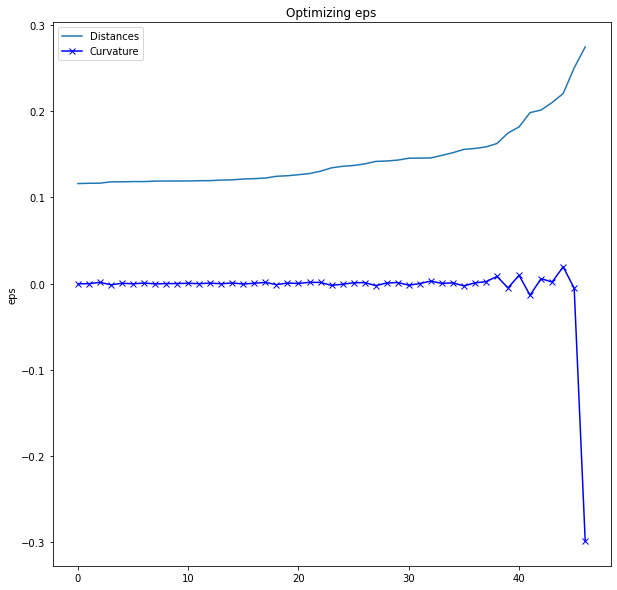

In [422]:
fig,ax = plt.subplots(figsize=(10,10))
#plt.figure(figsize=(16,8))
ax.plot(distances[500:],label='Distances')
ax.plot(curvature(distances)[500:],'bx-',label='Curvature')
plt.ylabel('eps')
#plt.ylabel('Curvature')
plt.title('Optimizing eps')
legend = ax.legend()
plt.savefig('optimal_eps.png')

In [167]:
distortions = []
K = range(1,10)
for k in K:
    df,dist = cluster_data_kmeans(df,n_clusters=k,features=features)
    distortions.append(dist)
K[np.argmax(curvature(distortions))]    

2

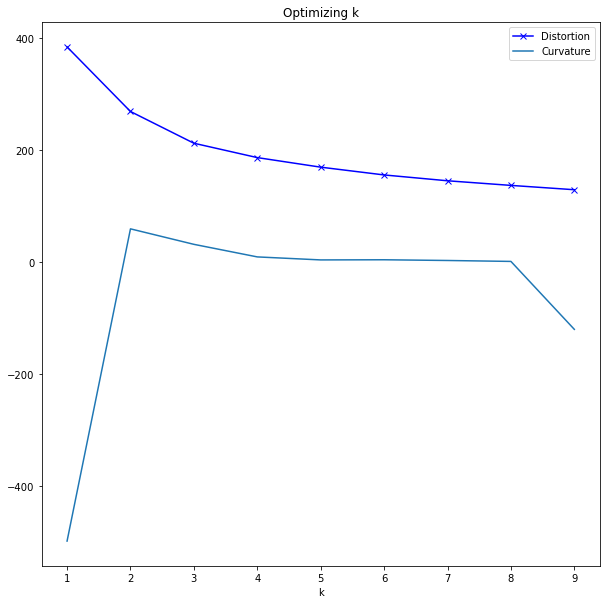

In [449]:
#plt.figure(figsize=(16,8))
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(K, distortions, 'bx-',label='Distortion')
ax.plot(K,curvature(distortions),label='Curvature')
plt.xlabel('k')
#plt.ylabel('Distortion')
plt.title('Optimizing k')
legend = ax.legend()
plt.savefig('optimal_k.png')
plt.show()

In [158]:
base_features = ['dbscan_cluster',None,None,None,'kmeans_cluster',None,None,None,
                 None,None,None,None,None,None,None,None,
                 'elevation', 'landcover', 'surface_pressure',
                 'ghi', 'air_temperature', 'dew_point', 'surface_albedo', 'cloud_type',
                 'wind_speed', 'relative_humidity', 'dni', 'solar_zenith_angle',
                 'total_precipitable_water', 'dhi', 'clearsky_dhi', 'clearsky_ghi',
                 'clearsky_dni', 'aod', 'cloud_press_acha','cld_opd_dcomp',
                 'cld_reff_dcomp','wind_direction','ozone','ssa']

In [159]:
feature_units = []
for b in base_features:
    try:
        feature_units.append(f[b].attrs['units'])
    except:
        feature_units.append('')       

In [173]:
f['ozone'].attrs['units']

'atm-cm'

In [187]:
def generate_figure(df,features,n_clusters=None,eps=None):
    feature_units = ['','','','','','','','','','','','','','','','',
                     'm','m2','hPa','W/m2','Celsius','Celsius',
                     'unitless',"type",'m/s','%','W/m2','degrees',
                     'cm','W/m2','W/m2','W/m2','W/m2','unitless','hPa',
                     '','','degrees','atm-cm','']
    if n_clusters is None:
        n_clusters = get_optimal_k(df,features)
    if eps is None:
        eps = get_optimal_eps(df,features)
    df = cluster_data_dbscan(df,
                             eps=eps,
                             features=features)
    df,dist = cluster_data_kmeans(df,
                                  n_clusters=n_clusters,
                                  features=features)
    
    base_features = ['dbscan_cluster',None,None,None,'kmeans_cluster',None,None,None,
                     None,None,None,None,None,None,None,None,
                    'elevation', 'landcover', 'surface_pressure',
                    'ghi', 'air_temperature', 'dew_point', 'surface_albedo', 'cloud_type',
                    'wind_speed', 'relative_humidity', 'dni', 'solar_zenith_angle',
                    'total_precipitable_water', 'dhi', 'clearsky_dhi', 'clearsky_ghi',
                    'clearsky_dni', 'aod', 'cloud_press_acha','cld_opd_dcomp',
                    'cld_reff_dcomp', 'wind_direction','ozone','ssa']
    
#titles = (f'*{f}*' if f in features else f'{f}' for f in base_features if f is not None)
    titles = (f'*{f}*' if f in features else f'{f}' for f in base_features if f is not None)

    fig = make_subplots(
    rows=5, cols=8,
    column_widths=[0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2],
    row_heights=[1,1,1,1,1,],
    specs=[
           [{"type":"scattergeo","rowspan":2,"colspan":4},None,None,None,{"type":"scattergeo","rowspan":2,"colspan":4},None,None,None],
           [None,None,None,None,None,None,None,None],
           [{"type":"scattergeo"},{"type":"scattergeo"},{"type":"scattergeo"},{"type":"scattergeo"},{"type":"scattergeo"},{"type":"scattergeo"},{"type":"scattergeo"},{"type":"scattergeo"}],
           [{"type":"scattergeo"},{"type":"scattergeo"},{"type":"scattergeo"},{"type":"scattergeo"},{"type":"scattergeo"},{"type":"scattergeo"},{"type":"scattergeo"},{"type":"scattergeo"}],
           [{"type":"scattergeo"},{"type":"scattergeo"},{"type":"scattergeo"},{"type":"scattergeo"},{"type":"scattergeo"},{"type":"scattergeo"},{"type":"scattergeo"},{"type":"scattergeo"}]],
    subplot_titles=list(titles))

    colorbar_x = [0.085+i*(1.0/8+0.003) for i in range(8)]
    colorbar_y = [0.92-i*(1.0/5+0.0135) for i in range(5)]

    for i,field in enumerate(base_features):
        if field is None:
            pass
        else:
            cbar_title = feature_units[i]
            row_idx = i//8
            col_idx = i%8
            #print(row_idx,col_idx)
            if row_idx==0:
                if col_idx==0:
                    fig = add_subplot(fig,field,row_idx+1,col_idx+1,0.335,0.85,clen=0.25,cbar_title=cbar_title)
                if col_idx==4:
                    fig = add_subplot(fig,field,row_idx+1,col_idx+1,0.85,0.85,clen=0.25,cbar_title=cbar_title)    
            else:        
                fig = add_subplot(fig,field,row_idx+1,col_idx+1,colorbar_x[col_idx],colorbar_y[row_idx],clen=0.14,cbar_title=cbar_title)

    fig.update_geos(scope='usa')
    fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
    height=675, width=1800,
    )
    for n,i in enumerate(fig['layout']['annotations']):
        if '*' in i['text']:# in features:
            i['font'] = dict(size=14,color='red')
        else:
            i['font'] = dict(size=14)       
    return fig

In [186]:
generate_figure(df,features,n_clusters=5,eps=0.1).show()

In [188]:
import plotly.graph_objects as go # or plotly.express as px
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output


base_features = ['elevation', 'landcover', 'surface_pressure',
                 'ghi', 'air_temperature', 'dew_point', 'surface_albedo', 'cloud_type',
                 'wind_speed', 'relative_humidity', 'dni', 'solar_zenith_angle',
                 'total_precipitable_water', 'dhi', 'clearsky_dhi', 'clearsky_ghi',
                 'clearsky_dni', 'aod', 'cloud_press_acha','wind_direction','ozone','ssa']

dropdown_options = []
for f in base_features:
    dropdown_options.append({'label':f,'value':f})

app = dash.Dash()

app.layout = html.Div([html.H6('NSRDB Clustering',style={'width':'100%', 'textAlign': 'center','font-size': '25px',"padding-top": "1px"}), 
    html.Div([
        "DBSCAN eps: ",
        dcc.Input(id='eps', value=None, type='text')
    ],style={'width': '49%', 'display': 'inline-block','textAlign':'center','height':'10px'}),
    html.Div([
        "KMeans n_clusters: ",
        dcc.Input(id='n_clusters', value=None, type='text')
    ],style={'width': '49%', 'display': 'inline-block','textAlign':'center'}),
    #html.H6('Feature Selection:',style={'width':'100%', 'textAlign': 'center','font-size': '26px'}),
    dcc.Dropdown(id='features',
    options=dropdown_options,
    value=['ghi'],
    multi=True,
    style={'width':'1800px', 'textAlign': 'center'}),
    html.Div([dcc.Graph(id='my-output')],style={'width':'90%','textAlign': 'center'}),
    dcc.Interval(
            id = 'graph-update',
            interval = 1000,
            n_intervals = 0
        )

],style={"width": "1800px",
         "height": "900px",
         "display": "inline-block",
         "border": "3px #5c5c5c solid",
         "padding-top": "1px",
         "padding-left": "1px",
         "overflow": "hidden"})


@app.callback(
    Output(component_id='my-output', component_property='figure'),
    [Input(component_id='eps', component_property='value'),
     Input(component_id='n_clusters', component_property='value'),
     Input(component_id='features', component_property='value')]
)
def update_output_div(eps,n_clusters,features):
    if eps is not None:
        try:
            eps = float(eps)
            if eps <= 0.0:
                eps = None
        except:
            eps = None
    if n_clusters is not None:
        try:
            n_clusters = int(n_clusters)
            if n_clusters <= 1:
                n_clusters = None
        except:
            n_clusters = None
    fig = generate_figure(df,features,n_clusters=n_clusters,eps=eps)
    return fig


#if __name__ == '__main__':
#    app.run_server(debug=True)


app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is run

INFO:__main__:Dash is running on http://127.0.0.1:8050/



 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


In [417]:
pio.write_image(fig,'clusters_3.png')

In [179]:
df.groupby(['dbscan_cluster']).mean()

,longitude,latitude,elevation,landcover,surface_pressure,ghi,air_temperature,dew_point,surface_albedo,cloud_type,...,dni,solar_zenith_angle,total_precipitable_water,dhi,clearsky_dhi,clearsky_ghi,clearsky_dni,aod,cloud_press_acha,kmeans_cluster
dbscan_cluster,,,,,,,,,,,,,,,,,,,,,
-1,-142.355377,52.803848,523.984863,163.076923,965.717949,99.452991,5.454274,2.020940,0.335983,5.085470,...,85.935897,90.132051,1.509402,57.576923,33.239316,186.470085,318.858974,0.068551,195.542735,0.923077
0,-98.796043,39.398140,788.276245,84.961240,928.913867,172.840762,11.189976,4.027918,0.237518,3.295758,...,209.731804,90.180590,1.815256,58.111434,39.439492,236.275947,358.876077,0.106338,108.163114,0.575581
1,-118.933334,36.136665,210.293335,31.333333,986.879630,223.379630,20.475000,1.914815,0.197685,1.694444,...,304.157407,90.166481,1.489815,56.435185,44.907407,251.759259,374.796296,0.136138,52.101852,0.333333
2,-154.596664,58.176666,214.665253,177.500000,991.101852,103.865741,2.791667,0.701389,0.228241,5.365741,...,106.763889,90.165833,1.260185,57.481481,32.787037,175.421296,332.328704,0.064558,224.611111,1.000000


In [177]:
df.groupby(['kmeans_cluster']).mean()

,longitude,latitude,elevation,landcover,surface_pressure,ghi,air_temperature,dew_point,surface_albedo,cloud_type,...,solar_zenith_angle,total_precipitable_water,dhi,clearsky_dhi,clearsky_ghi,clearsky_dni,aod,cloud_press_acha,dbscan_cluster,kmeans_cluster
14294,-155.660004,18.930000,66.263161,140,1044.833333,233.722222,27.433333,21.761111,0.155000,3.055556,...,90.030000,4.222222,75.722222,46.166667,272.222222,326.555556,0.093228,60.055556,-1,1
59813,-105.339996,31.090000,1390.359985,130,872.888889,201.666667,17.227778,1.733333,0.213889,2.111111,...,90.137778,1.738889,45.611111,33.777778,272.055556,391.444444,0.067278,108.777778,0,0
63693,-111.980003,31.650000,738.039978,130,930.944444,254.833333,21.233333,5.177778,0.223333,2.000000,...,90.143333,1.761111,60.055556,40.277778,272.055556,398.833333,0.071472,45.166667,0,0
65542,-110.099998,31.889999,1363.650024,130,859.888889,241.888889,16.827778,3.172222,0.169444,2.333333,...,90.145556,1.600000,44.888889,33.944444,273.277778,407.166667,0.062811,33.055556,0,0
67029,-111.339996,32.090000,775.239990,130,924.500000,225.722222,21.283333,4.444444,0.183333,2.277778,...,90.144444,1.800000,60.555556,37.055556,270.555556,401.222222,0.066511,44.277778,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1380886,-69.820000,44.090000,41.439999,50,1015.611111,156.777778,7.477778,4.194444,0.329444,3.333333,...,90.228889,1.894444,57.000000,40.888889,217.000000,357.944444,0.094233,84.500000,0,1
1396429,-69.339996,45.169998,170.360001,50,1000.944444,159.277778,5.388889,2.161111,0.383333,4.444444,...,90.229444,1.577778,68.722222,38.388889,216.055556,364.555556,0.085522,176.277778,0,1
1412545,-68.820000,44.810001,50.840000,50,1013.611111,164.277778,6.338889,3.061111,0.357778,4.555556,...,90.228889,1.672222,70.611111,39.388889,216.611111,362.888889,0.092872,154.388889,0,1
1428882,-68.300003,45.770000,174.350006,50,997.888889,153.000000,4.388889,1.094444,0.458889,4.388889,...,90.230000,1.461111,64.000000,36.555556,215.833333,371.833333,0.084206,181.222222,0,1


In [447]:
fig = go.Figure(go.Scattergeo(
        lon = df['longitude'],
        lat = df['latitude'],
        text = get_corrs(df,features=features),
        mode = 'markers',
        marker_color = get_corrs(df,features=features),
        marker = dict(colorscale='inferno',colorbar=dict(x=1.0,y=0.5,len=0.6)),
        showlegend=False,
        ))

fig.update_geos(scope='usa')
fig.update_layout(
    title={
        'text': 'Correlations with NREL',
        'y':0.9,
        'x':0.5},
    title_font_size=40,
    margin=dict(l=20, r=20, t=40, b=5),
    paper_bgcolor="LightSteelBlue",
    height=800, width=1100,
)
fig.show()

In [448]:
pio.write_image(fig,'correlations_1.png')